In [1]:
import pickle
import tqdm
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from utils import  load_params, visualization
import PIL
import tqdm

In [2]:
lottery_objs = load_params.load_lotteries()
set_dicts = load_params.load_set_dicts()
behavior_results = load_params.load_behavior_results()
set_objs = load_params.load_sets(behavior_results)
first_subjects, replication_subjects = load_params.load_samples(roi_type='roi')
first_subjects_schaefer, replication_subjects_schaefer = load_params.load_samples(roi_type='schaefer')

In [3]:
with open('../../data/rdms/lottery_attribute_rdm.pkl', 'rb') as f:
    lottery_attribute_rdm = pickle.load(f)
with open('../../data/rdms/lottery_attribute_wo_alex_1st_rdm.pkl', 'rb') as f:
    attribute_without_alex_rdm = pickle.load(f)

### whole brain attribute representation levels

In [4]:
def correlate_attribute_neural_rdms(rdms, attribute_rdm=lottery_attribute_rdm, roi_type='schaefer'):
    rois = rdms.keys()
    if roi_type=='schaefer':
        labels = [int(roi.split('_')[1]) for roi in rois]
        attribute_nerual_rdm_corr = pd.DataFrame({'area':rois, 'label':labels})
    else:
        labels = rois
        attribute_nerual_rdm_corr = pd.DataFrame({'area':rois})
    tril_ind = np.tril_indices(attribute_rdm.shape[0], k=-1)
    for i, roi in enumerate(rois):
        roi_rdm = rdms[roi]
        rdm_corr = np.corrcoef(roi_rdm[tril_ind], attribute_rdm[tril_ind])[0, 1]
        attribute_nerual_rdm_corr.loc[i, 'rdm_r'] = rdm_corr
    return attribute_nerual_rdm_corr

In [5]:
with open('../../data/rdms/full_schaefer_first_rdms.pkl', 'rb') as f:
    full_schaefer_first_rdms = pickle.load(f)
with open('../../data/rdms/full_schaefer_replication_rdms.pkl', 'rb') as f:
    full_schaefer_replication_rmds = pickle.load(f)

In [6]:
with open('../../data/rdms/full_roi_first_rdms.pkl', 'rb') as f:
    first_subjects_roi_rdms = pickle.load(f)
with open('../../data/rdms/full_roi_replication_rdms.pkl', 'rb') as f:
    replication_subjects_roi_rdms = pickle.load(f)

In [7]:
first_attribute_level = correlate_attribute_neural_rdms(first_subjects_roi_rdms, attribute_rdm=lottery_attribute_rdm, roi_type='roi')
replication_attribute_level = correlate_attribute_neural_rdms(replication_subjects_roi_rdms, attribute_rdm=lottery_attribute_rdm, roi_type='roi')

first_attribute_alex_level = correlate_attribute_neural_rdms(first_subjects_roi_rdms, attribute_rdm=attribute_without_alex_rdm, roi_type='roi')
replication_attribute_alex_level = correlate_attribute_neural_rdms(replication_subjects_roi_rdms, attribute_rdm=attribute_without_alex_rdm, roi_type='roi')

In [8]:
first_schaefer_attribute_level = correlate_attribute_neural_rdms(full_schaefer_first_rdms, attribute_rdm=lottery_attribute_rdm)
replication_schaefer_attribute_level = correlate_attribute_neural_rdms(full_schaefer_replication_rmds, attribute_rdm=lottery_attribute_rdm)

first_schaefer_attribute_alex_level = correlate_attribute_neural_rdms(full_schaefer_first_rdms, attribute_rdm=attribute_without_alex_rdm)
replication_schaefer_attribute_alex_level = correlate_attribute_neural_rdms(full_schaefer_replication_rmds, attribute_rdm=attribute_without_alex_rdm)

In [25]:
# visualization.write_schaefer_results_to_surface(replication_schaefer_attribute_level, result_column='rdm_r',
#                                                 output_file_path="replication_attribute_representation_level.dtseries.nii')

### plot attribute representation levels

In [9]:
with open('../../data/rdms/full_roi_first_rdms.pkl', 'rb') as f:
    first_rdms = pickle.load(f)
with open('../../data/rdms/full_roi_replication_rdms.pkl', 'rb') as f:
    replication_rdms = pickle.load(f)

In [10]:
def norm_rdm_for_plot(rdm, vmin, vmax):
    rdm[np.diag_indices(rdm.shape[0])] = np.nan
    rdm = (vmax - vmin) * ((rdm - np.nanmin(rdm)) / (np.nanmax(rdm) - np.nanmin(rdm))) + vmin
    return rdm

In [13]:
def plot_rdms_with_attribute_level(subjects_roi_rdms, lottery_attribute_rdm=lottery_attribute_rdm, attribute_without_alex_rdm=attribute_without_alex_rdm):
    vmin = 0
    vmax = 1
    cmap = 'Blues'
    rois = list(subjects_roi_rdms.keys())
    rois.remove('whole_brain')
    n_rois = len(rois)

    base_rdm = lottery_attribute_rdm.astype(float)
    base_rdm = norm_rdm_for_plot(base_rdm, vmin, vmax)
    base_rdm_partial = attribute_without_alex_rdm.astype(float)
    base_rdm_partial = norm_rdm_for_plot(base_rdm_partial, vmin, vmax)

    n_rows = 2
    n_cols = int(np.ceil((n_rois + 1) / n_rows))
    fig, axs = plt.subplots(2, n_cols, figsize=(14, 8), dpi=300)
    axs = axs.flatten()
    axs[0].imshow(base_rdm, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0].tick_params(labelsize=13)
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    roi_similarity_df = pd.DataFrame(columns=['roi', 'r', 'pval', 'partial_r', 'partial_pval'])
    for i, roi in enumerate(rois):
        avg_rdm = subjects_roi_rdms[roi]
        tril_ind = np.tril_indices(avg_rdm.shape[0], k=-1)
        pearson_r, p = scipy.stats.pearsonr(avg_rdm[tril_ind], base_rdm[tril_ind])
        partial_r, partial_p = scipy.stats.pearsonr(avg_rdm[tril_ind], base_rdm_partial[tril_ind])
        roi_similarity_df.loc[i, 'roi'] = roi
        roi_similarity_df.loc[i, 'r'] = pearson_r
        roi_similarity_df.loc[i, 'pval'] = p
        roi_similarity_df.loc[i, 'partial_r'] = partial_r
        roi_similarity_df.loc[i, 'partial_pval'] = partial_p

    roi_similarity_df = roi_similarity_df.sort_values('r', ascending=False).reset_index(drop=True)
    for i, roi in enumerate(roi_similarity_df.roi):
        avg_rdm = subjects_roi_rdms[roi]
        avg_rdm = norm_rdm_for_plot(avg_rdm, vmin, vmax)
        rdm_plot = axs[i+1].imshow(avg_rdm, cmap=cmap, vmin=vmin, vmax=vmax)
        axs[i+1].tick_params(labelsize=13)
        axs[i+1].set_xticks([])
        axs[i+1].set_yticks([])  
        pearson_r = roi_similarity_df.loc[i, 'r'] 
        partial_r = roi_similarity_df.loc[i, 'partial_r'] 
        axs[i+1].set_title(f'{roi}, {pearson_r:.2f}, {partial_r:.2f}', fontsize=8)
    axs[i+2].remove()
    plt.show()
    return roi_similarity_df

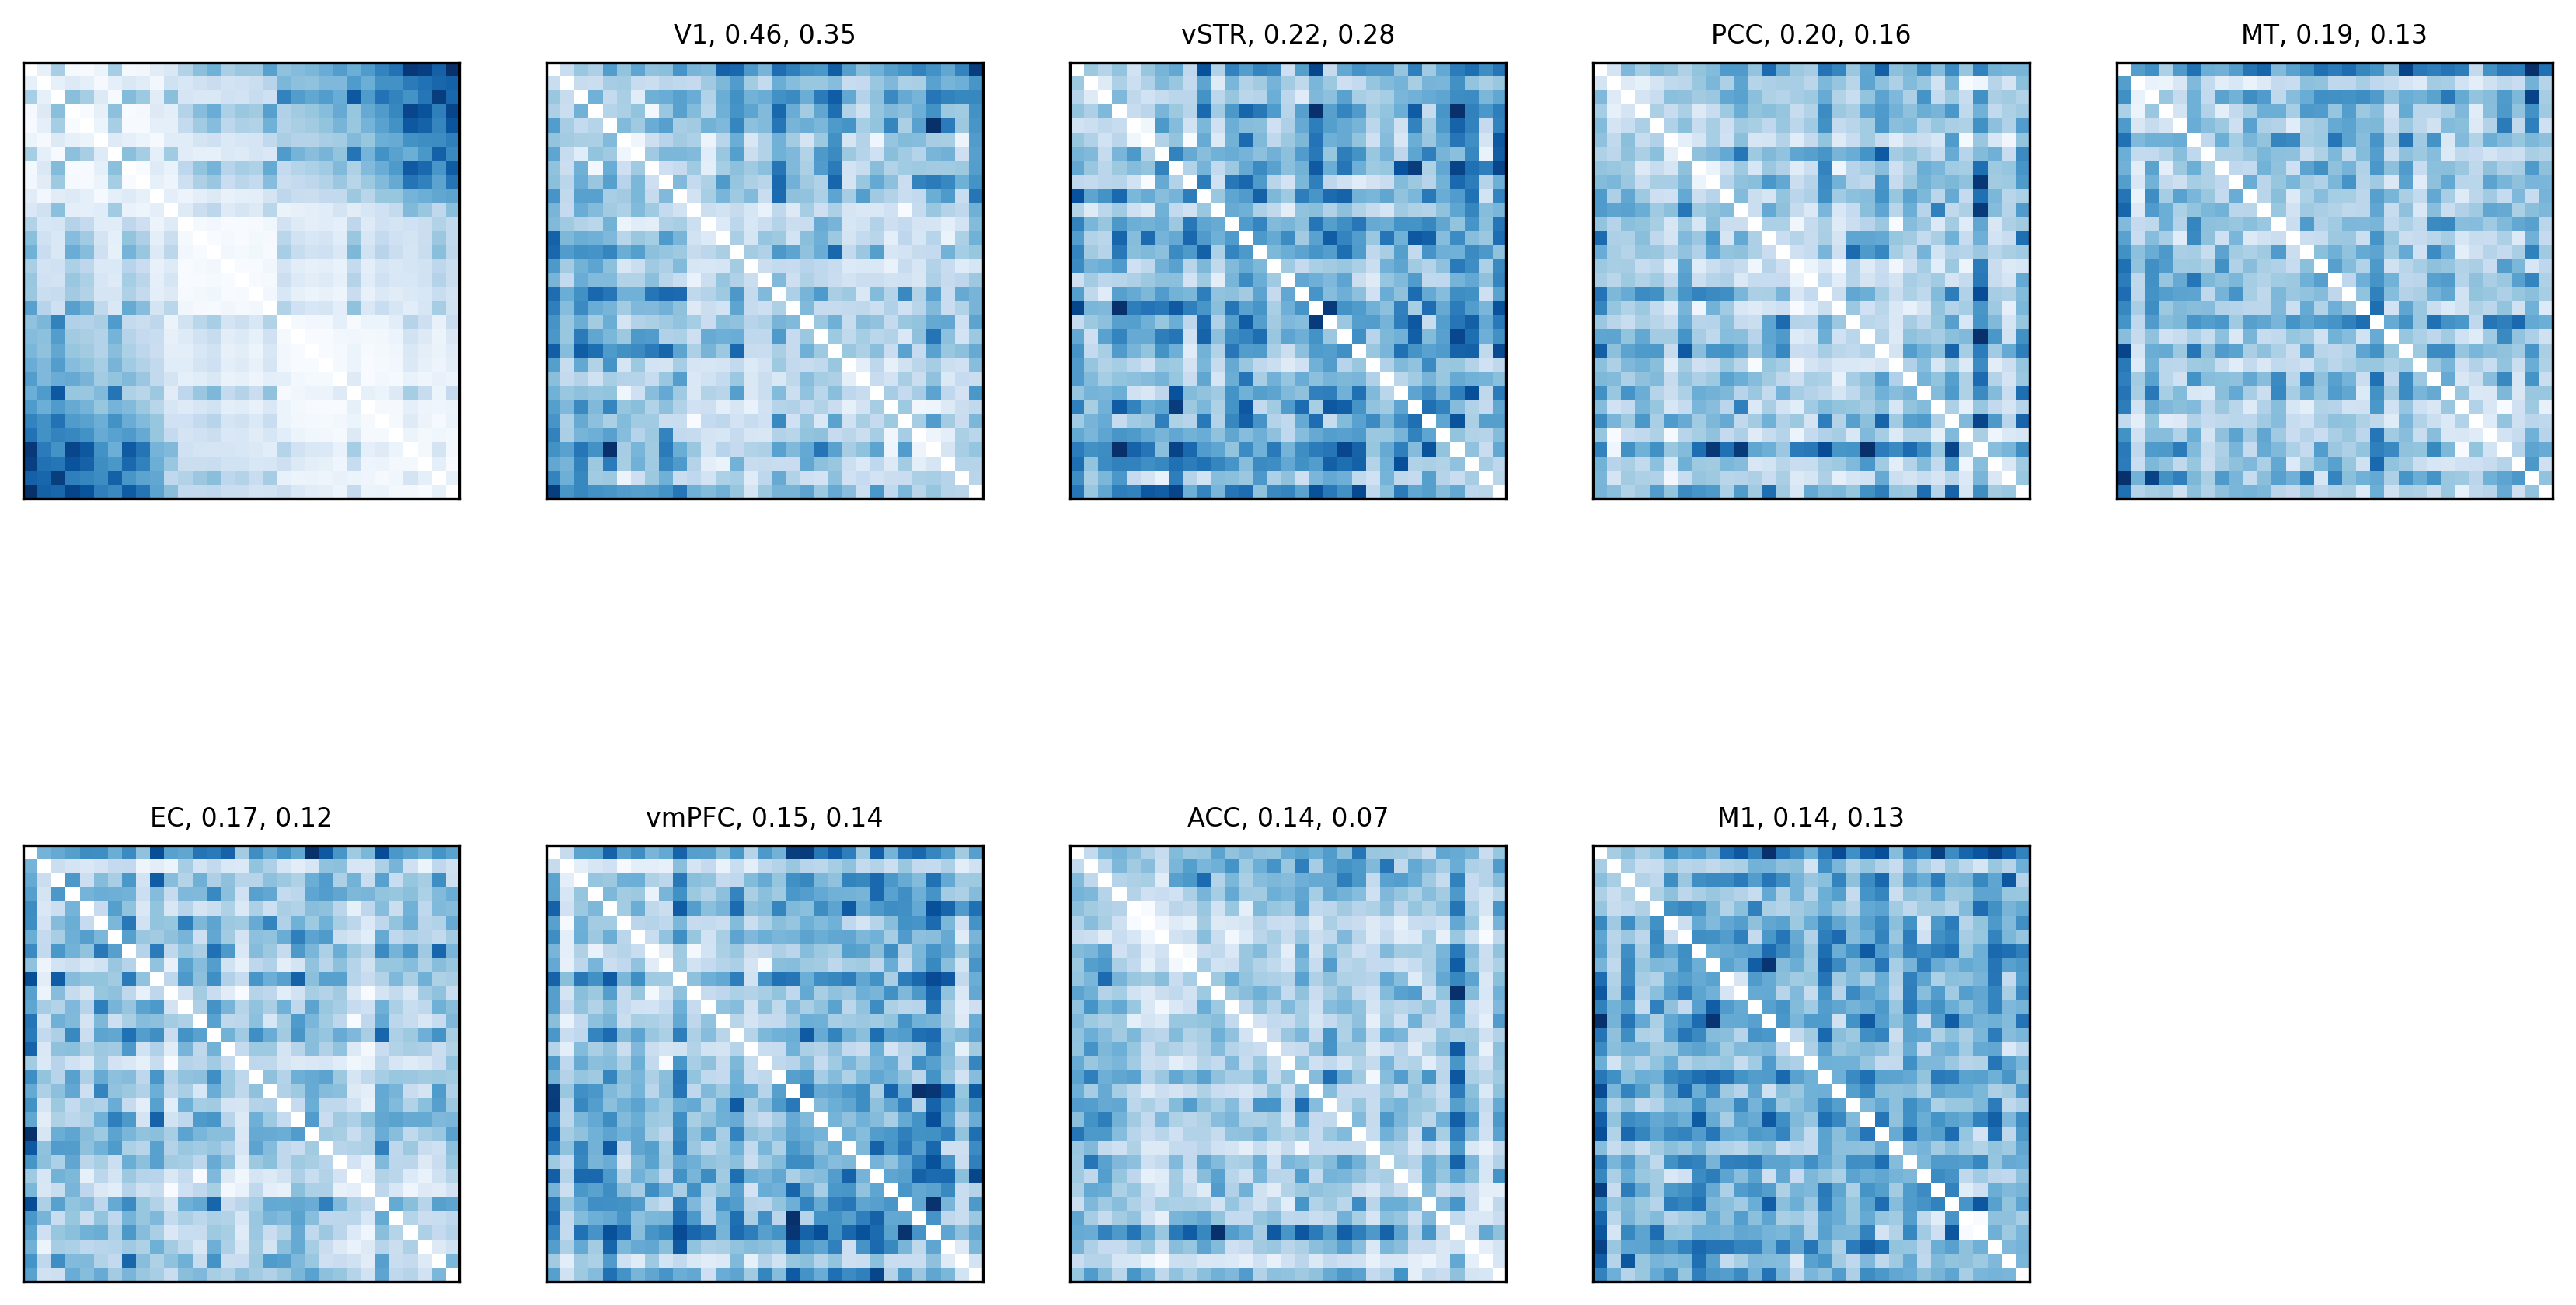

,roi,r,pval,partial_r,partial_pval
0,V1,0.456008,0.0,0.345061,0.0
1,vSTR,0.221109,0.000001,0.27648,0.0
2,PCC,0.20137,0.000012,0.157145,0.000672
3,MT,0.186796,0.000051,0.130282,0.004896
4,EC,0.169082,0.00025,0.120152,0.009504
5,vmPFC,0.148939,0.001277,0.144735,0.001753
6,ACC,0.140966,0.002313,0.073293,0.114488
7,M1,0.139004,0.002665,0.13317,0.004018


In [14]:
plot_rdms_with_attribute_level(first_subjects_roi_rdms)

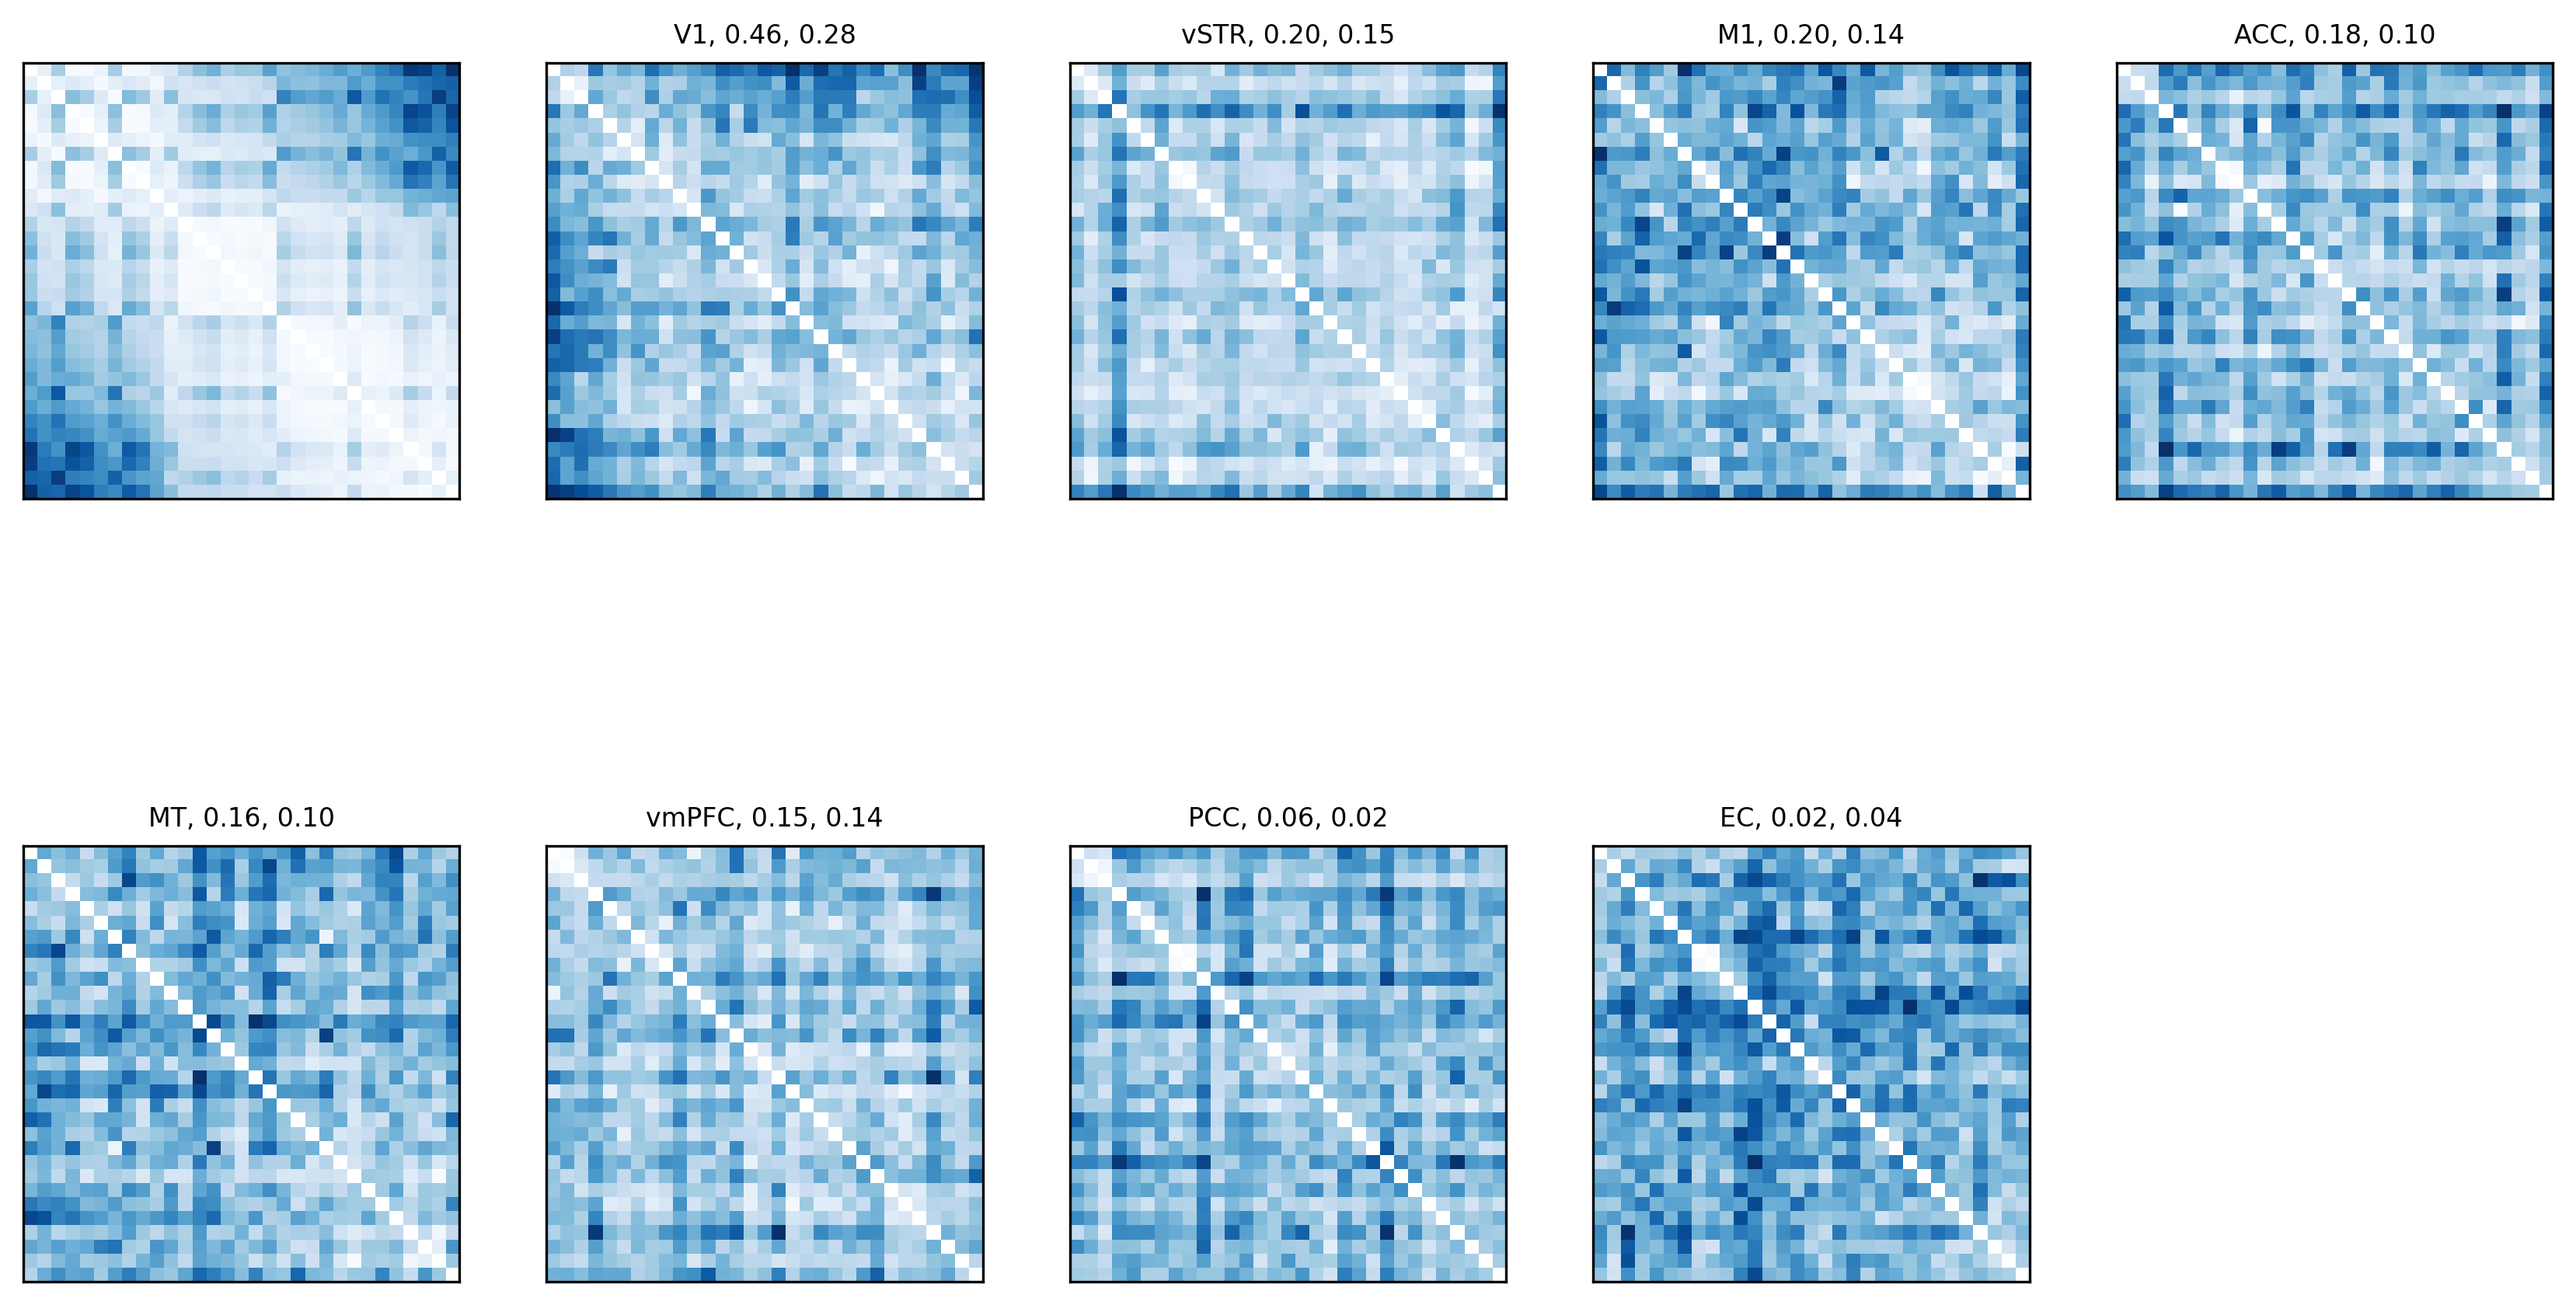

,roi,r,pval,partial_r,partial_pval
0,V1,0.46143,0.0,0.275244,0.0
1,vSTR,0.202164,0.000011,0.154921,0.000802
2,M1,0.195431,0.000022,0.140411,0.002408
3,ACC,0.176194,0.000134,0.097406,0.035747
4,MT,0.159501,0.000556,0.10309,0.026218
5,vmPFC,0.14642,0.001546,0.142979,0.001996
6,PCC,0.063156,0.173964,0.015562,0.737861
7,EC,0.016166,0.728074,0.036404,0.433538


In [16]:
plot_rdms_with_attribute_level(replication_subjects_roi_rdms)

In [12]:
def plot_coords_vs_rdm_corr(coords_reg, coords_reg_wo_alex, column='first_rdm_corr', save_path=None):
    two_d_lm = sm.OLS(coords_reg[column], sm.add_constant(coords_reg[['y', 'y_squared']])).fit()
    two_d_lm_alex = sm.OLS(coords_reg_wo_alex[column], sm.add_constant(coords_reg_wo_alex[['y', 'y_squared']])).fit()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300, sharey=True)
    ticksize = 16
    labelsize = 20 

    parabola = np.poly1d(np.polyfit(coords_reg.y, coords_reg[column], 2))
    axs[0].scatter(coords_reg.y, coords_reg[column], alpha=0.7, c='#bc4749')
    axs[0].plot(coords_reg.sort_values('y').y, parabola(coords_reg.sort_values('y').y), c='grey')
    axs[0].set_ylabel('Attribute representation level', fontsize=labelsize)
    axs[0].set_xlabel('Posterior-Anterior coordinate', fontsize=labelsize)
    pvalue_exp = int(np.log10(two_d_lm.f_pvalue)) + 1
    axs[0].text(-60, 0.56, f'Adj. R$^{2}$={two_d_lm.rsquared_adj:.4f}' + f', $p < 10^{{{pvalue_exp}}}$', style='italic', fontsize=ticksize)
    xticks = axs[0].get_xticks()
    yticks = axs[0].get_yticks()
    xlabels = axs[0].get_xticklabels()
    ylabels = axs[0].get_yticklabels()
    axs[0].set_xticks(xticks[::2])
    axs[0].set_xticklabels(xlabels[::2], fontsize=ticksize)
    axs[0].set_yticks(yticks[::2])
    axs[0].set_yticklabels(ylabels[::2], fontsize=ticksize)
    # without alexnet
    wo_alexnet_parabola = np.poly1d(np.polyfit(coords_reg_wo_alex.y, coords_reg_wo_alex[column], 2))
    axs[1].scatter(coords_reg_wo_alex.y, coords_reg_wo_alex[column], alpha=0.7, c='#bc4749')
    axs[1].plot(coords_reg_wo_alex.sort_values('y').y, wo_alexnet_parabola(coords_reg_wo_alex.sort_values('y').y), c='grey')
    axs[1].set_xlabel('Posterior-Anterior coordinate', fontsize=labelsize)
    pvalue_exp = int(np.log10(two_d_lm_alex.f_pvalue)) + 1
    axs[1].text(-60, 0.56, f'Adj. R$^{2}$={two_d_lm_alex.rsquared_adj:.4f}' + f', $p < 10^{{{pvalue_exp}}}$', style='italic', fontsize=ticksize)
    xticks = axs[1].get_xticks()
    xlabels = axs[1].get_xticklabels()
    axs[1].set_xticks(xticks[::2])
    axs[1].set_xticklabels(xlabels[::2], fontsize=ticksize)
    plt.ylim([-0.2, 0.6])
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')

In [13]:
coords_reg = pd.read_csv('../../results/coords_regression.csv')
coords_reg_wo_alex = pd.read_csv('../../results/coords_regression_wo_alexnet.csv')

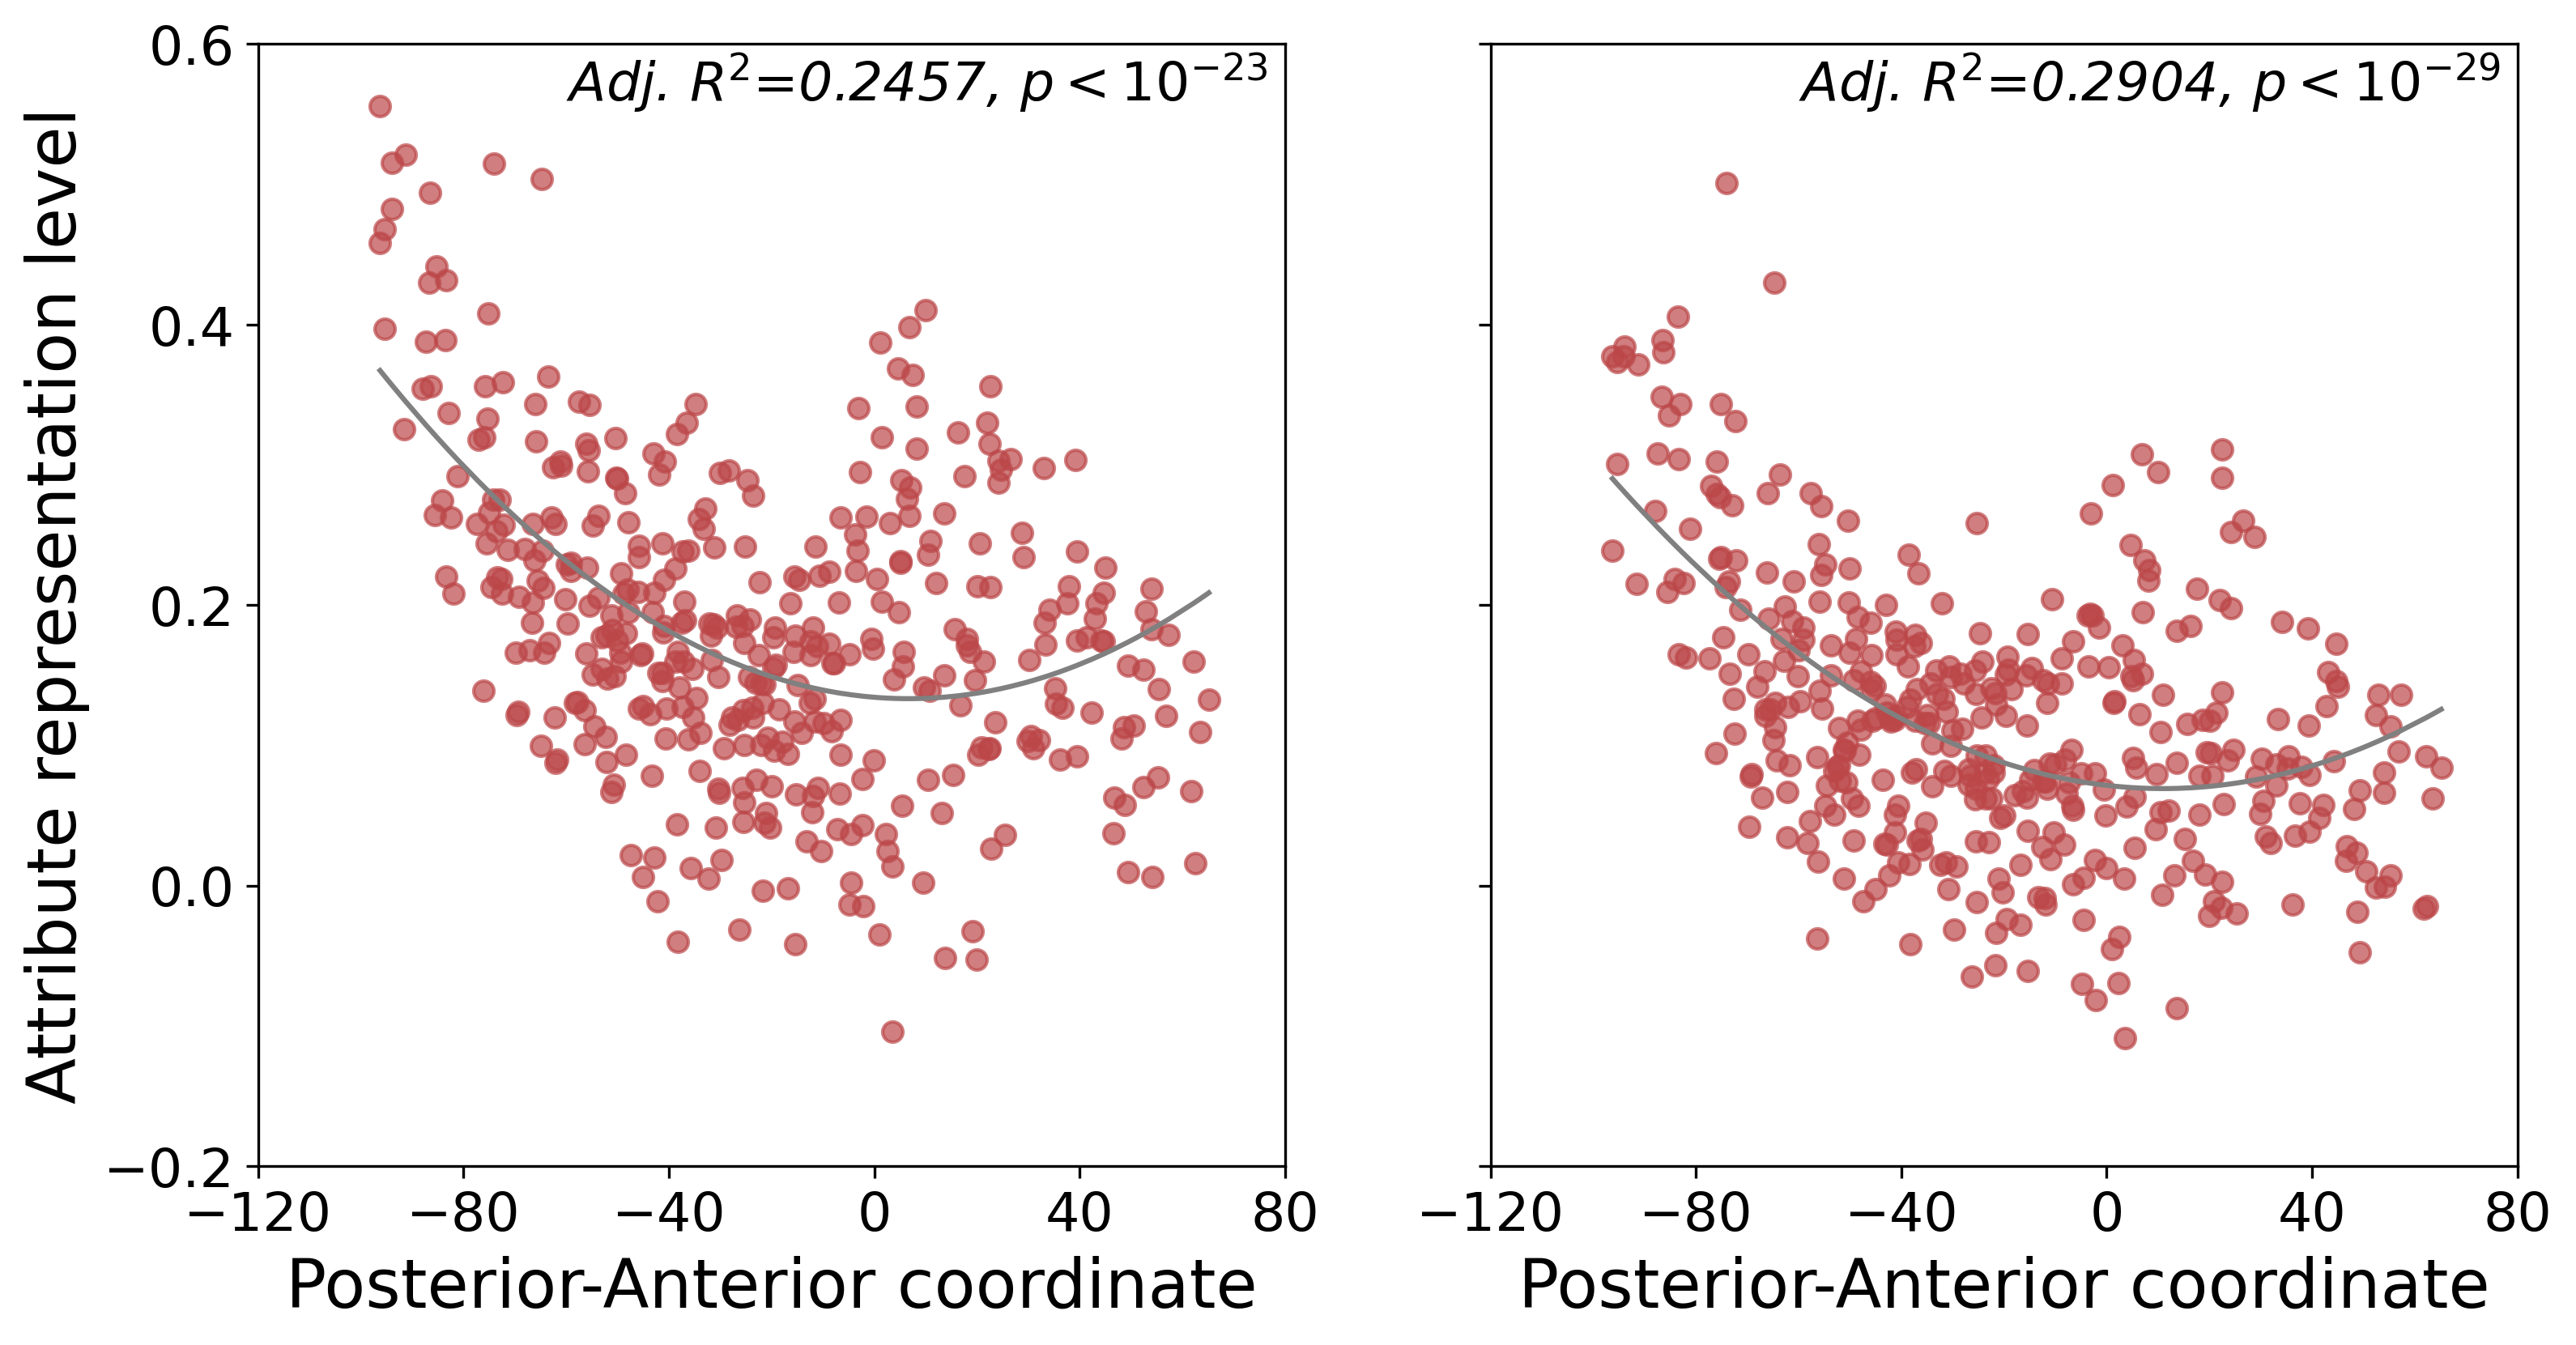

In [14]:
plot_coords_vs_rdm_corr(coords_reg, coords_reg_wo_alex, 'first_rdm_corr')#, save_path='../../results/figs/fig3/first_coords.png')

### control for perceptual similarity with AlexNet

In [ ]:
import torch
from torchvision import transforms

In [ ]:
lotteries = pd.read_csv('../../stimuli/evaluation_stimuli.csv', index_col=0)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()
model = model.double()

Using cache found in /home/asaf/.cache/torch/hub/pytorch_vision_v0.10.0
/home/asaf/miniconda3/envs/gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/asaf/miniconda3/envs/gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def prep_for_alex(img):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0).double()
    return input_batch

def get_alex_layer_rep(model, x, layer=1):
    if layer==1:
        stop_step = 1 # first conv layer
    elif layer==2:
        stop_step = 4
    elif layer==3:
        stop_step = 7
    model.eval()
    subset_model = model.features[:stop_step]
    output = subset_model(x)
    output = output.detach().numpy().flatten()
    return output

In [ ]:
alex_layer_reps = []
lottery_ids = np.arange(1, 32)
for lottery_i in tqdm.tqdm(lottery_ids):
    img = PIL.Image.open(f'../../stimuli/pngs/lottery_{lottery_i}.png').convert('RGB')
    preped_img = prep_for_alex(img)
    first_layer_rep = get_alex_layer_rep(model, preped_img, layer=1)
    alex_layer_reps.append(first_layer_rep)

100%|██████████| 31/31 [00:00<00:00, 52.91it/s]


In [ ]:
alex_rdm = pd.DataFrame()
alex_layer = 1
inds = np.arange(31)
for i in tqdm.tqdm(inds):
    for j in inds[i:]:
        alex_mse = mean_squared_error(alex_layer_reps[i], alex_layer_reps[j])
        alex_rdm.loc[i, j] = alex_mse
        alex_rdm.loc[j, i] = alex_mse

100%|██████████| 31/31 [00:00<00:00, 41.13it/s]


In [ ]:
def regress_out_rdms(lottery_attribute_rdm, other_rdm):
    tril_ind = np.tril_indices_from(lottery_attribute_rdm, k=-1)
    y = lottery_attribute_rdm[tril_ind]
    other_rdm_X = other_rdm.values[tril_ind]
    attribute_other_ols = sm.OLS(y, sm.add_constant(other_rdm_X)).fit()
    attribute_other_resid = attribute_other_ols.resid
    attribute_resid_rdm = lottery_attribute_rdm.copy()
    attribute_resid_rdm[tril_ind] = attribute_other_resid
    attribute_resid_rdm.T[tril_ind] = attribute_other_resid
    return attribute_resid_rdm

In [ ]:
attribute_without_alex1st = regress_out_rdms(lottery_attribute_rdm, alex_rdm)